# Useful segmentation tricks with the watershed transform

The *watershed transform* is a powerful and easy to use segmentation algorithm, and very reliable if an appropriate marker generation procedure can be created. In this notebook we introduce a variety of tricks that can be used when creating markers. We illustrate for the *coins* image example, although they are useful in a variety of scenarios.

The takeaway points are:

1. Develop the markers in stages
1. Don't be scared to use large filters - making the image unrecognisable usually doesn't matter during marker generation
1. Return to the original image when performing segmentation.

## Watershed transform background

The *watershed transform using markers* is a long established tool for segmentation that is introduced [here](https://scikit-image.org/docs/0.14.x/user_guide/tutorial_segmentation.html)

The important factors to understand about the watershed transform are:

1. Regions are grown from a set of "markers"
1. All image pixels are assigned to exactly one marker (or as a boundary) - that means that at least two marker classes are required to split the image into multiple regions
1. Boundaries between regions occur along ridge lines, or peaks, in the image topology (or midpoints of plateaus). There is no threshold step involved.
1. Markers lie entirely within the region to be segmented. Markers that cross region boundaries will lead to undesirable results.

## Plans

We're going to do things a bit differently to the other coin examples floating around. Firstly, we will pretend there isn't a reliable way of creating a background marker and  invest our effort in creating reliable foreground markers using big filters. We'll then perform two phases of watershed transform segmentation, the first of which will create our background markers.

# The problem

As in other examples using this *coin* image, the problem is to create an accurate, labelled, mask for each coin.

We begin with some setup and a general look at the input data. We create two helper functions.

In [ ]:
def image_show(image, cmap='gray', **kwargs):
    """ showing a single image, using matplotlib, with predefined figure size and in greyscale """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.imshow(image, cmap=cmap)
    ax.axis('off')
    return fig, ax


def image_show_multi(imlist, nrows=1, ncols=1, cmap='gray'):
    """ showing multiple images side by side on one plot,
    using imlist, list of image object refrences """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))
    i=0
    for r in range(nrows):
        for c in range(ncols):
            ax[i].imshow(imlist[i])
            ax[i].axis('off')
            i=i+1

    return fig, ax

Importing the required python modules and loading the *coins* image data from `SciKit Image (skimage)` examples.

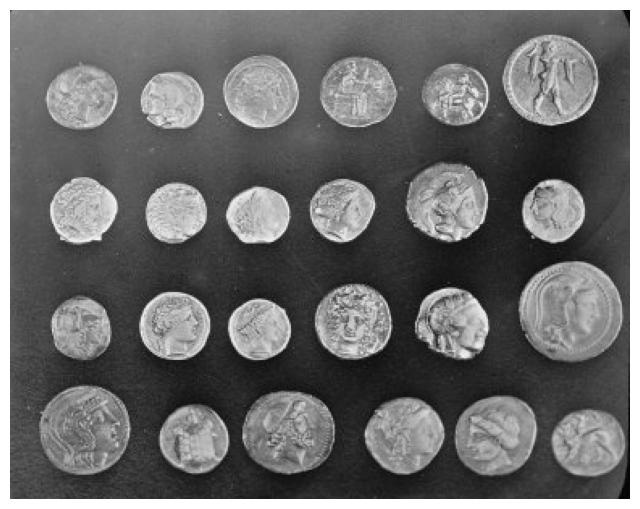

In [ ]:
import numpy as np
import skimage
from skimage import data
import matplotlib.pyplot as plt
coins = data.coins()

img = image_show(coins)

# Foreground markers

Reliable segmentation using the watershed transform requires a single marker per coin. In addition, the marker must not cross the coin boundary.

We begin by making some observations about the scene we want to segment:

1. Coins are bright, but textured (see thresholding results in other tutorials, and the image intensity profile at a special cross-section of the coins (3rd row) below)
1. Size varies, but not dramatically - the largest coin is probably about twice the diameter of the smallest.


image size:  (303, 384)


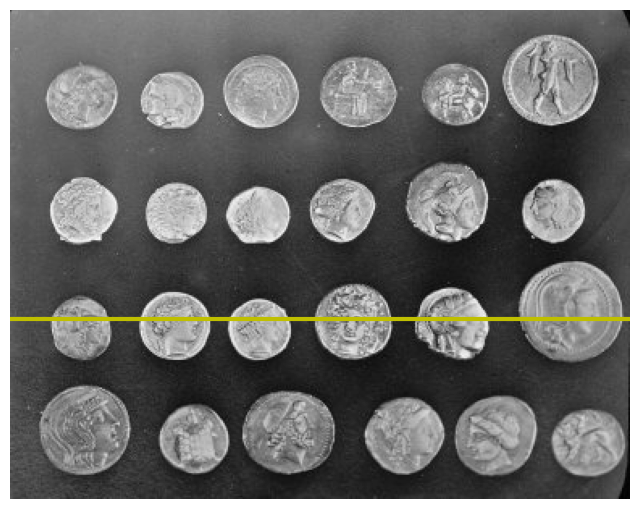

Text(0, 0.5, 'pixel intensity (brightness)')

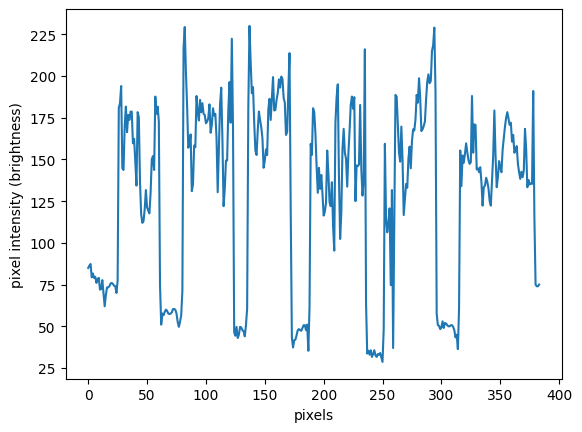

In [ ]:
print('image size: ', coins.shape)
img = image_show(coins)
width = coins.shape[1]
plt.plot(range(width),[191]*width, '-y', lw=3)
plt.show()
#plotting pixel values at row 190 (yellow line)
fig, ax = plt.subplots()
ax.plot(range(coins.shape[1]), np.mean(coins[190:193,:], axis=0))
ax.set_xlabel('pixels')
ax.set_ylabel('average pixel intensity (brightness)')

Our first attempt at finding markers will be to apply a very large Gaussian smoothing ([SkImage Gaussian filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)), with a sigma value a substantial proportion of the size of the smallest coin (here set to 10), and find regional maxima (peaks) in that image. (additional python modules loaded for later use.)

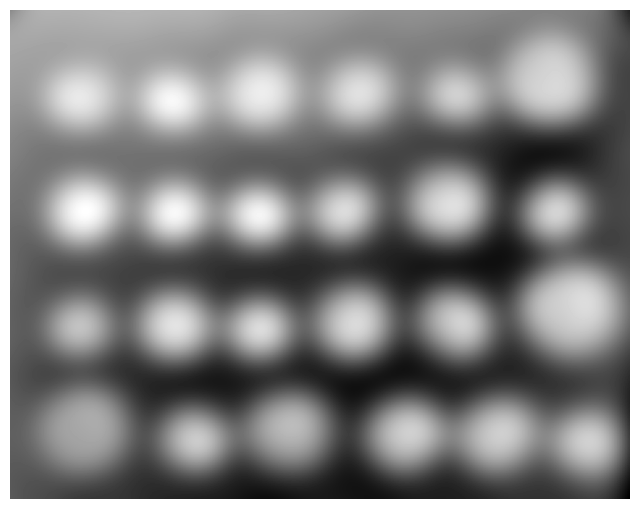

In [ ]:
from skimage import filters
from skimage import morphology
from skimage import feature
from skimage import color
from skimage import measure
from skimage import segmentation

smoothed = skimage.filters.gaussian(coins, 10) # (image, sigma value)
img = image_show(smoothed)

Now we find the local maxima (peaks) and dilate them.

 We use the `min_distance` parameter of `peak_local_max` in combination with the large smoothing kernel (image: *smoothed*) to reduce the chance of having multiple markers in a coin.

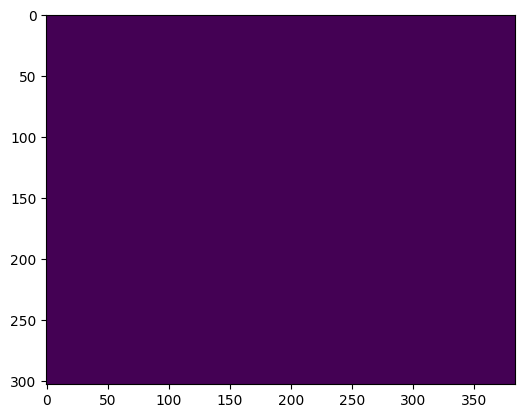

In [ ]:
peak_idx = skimage.feature.peak_local_max(smoothed, min_distance=10) #generate a list of peak point index pairs
peak_mask = np.zeros_like(smoothed, dtype=bool) # create an image sized black array; smoothed or coins can be (size) sample

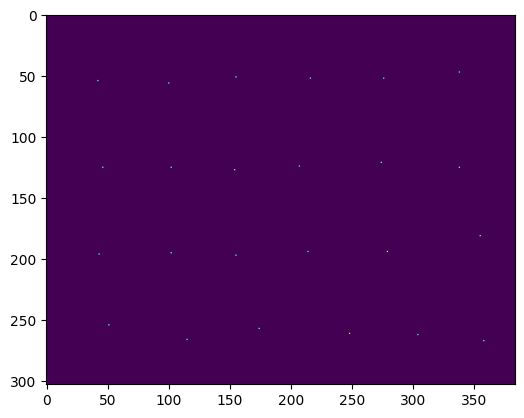

In [ ]:
peak_mask[tuple(peak_idx.T)] = True
# for demonstration of the found peak points
plt.imshow(peak_mask)

<ipython-input-30-e740a90c9945>:2: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  peak_mask = skimage.morphology.dilation(peak_mask, footprint=skimage.morphology.square(11))


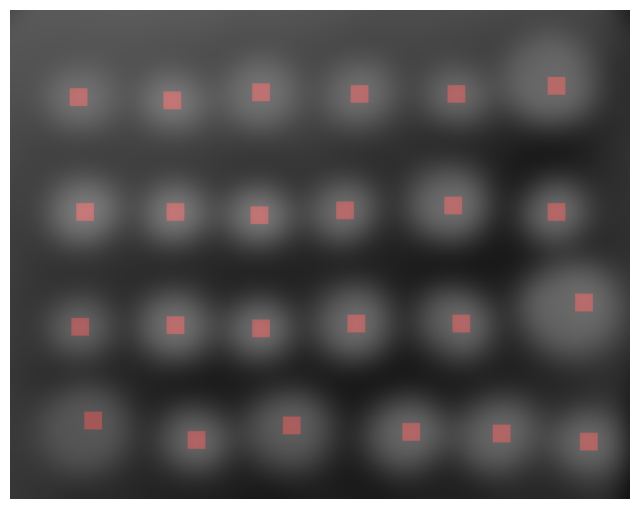

In [ ]:
# dilate them to 11 pixel sized squares, and label
try:
  peak_mask = skimage.morphology.dilation(peak_mask, footprint=skimage.morphology.square(11)) # skimage version < 0.27
except:
  peak_mask = skimage.morphology.dilation(peak_mask, footprint=skimage.morphology.footprint_rectangle(11)) # skimage version > 0.27

# display
peak_overlay = skimage.color.label2rgb(peak_mask, image=smoothed, bg_label=0)
img = image_show(peak_overlay)

Now we have a nice square marker inside each coin.

Now we need to create a marker for the background. We're going to do something a bit different this time - use the *watershed to tesselate* * the scene, then take the boundary lines to use as markers in a second watershed ([SkImage Watershed segmentation](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed)).

'* tesselation: covering a surface using one or more geometric shapes, called tiles, with no overlaps and no gaps.'

The steps are:

1. Label the peak markers (record the number of peaks for later)
1. Invert the greyscale smoothed image (intensities)
1. Apply a watershed that produces border regions
1. Select the boundary
1. Combine with the peak markers.

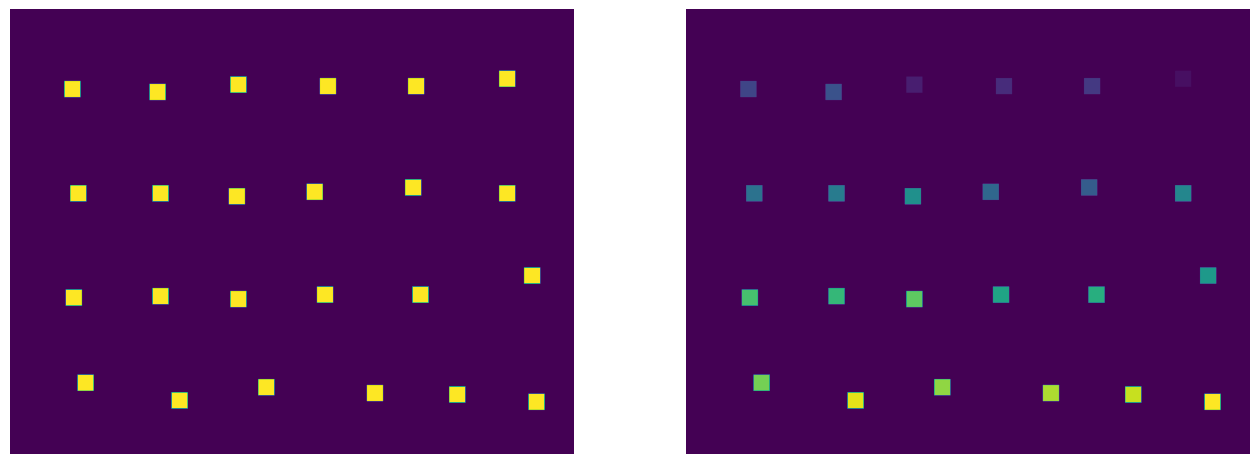

In [ ]:
# label peak markers
# labelpeaks: array representing peaks, similar to peak_overlay, but with colored markers
# totalpeaks: number of peaks found (int)
labelpeaks, totalpeaks = skimage.measure.label(peak_mask, return_num = True)
# demonstration
img = image_show_multi([peak_mask, labelpeaks], nrows=1, ncols=2)

*labelpeaks* is a similar array to *peak_masks*, but the markers are (counted) labeled, thus are represented with different colors.

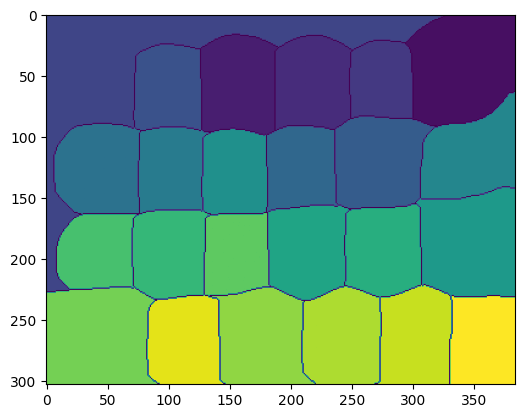

In [ ]:
#invert smoothed image
smoothed_inverted = np.max(smoothed) - smoothed
# watershed segmentation of inverted image, with markers
# watershed_line = True, a one-pixel wide line separates the regions obtained by the watershed algorithm.
phase1seg = skimage.segmentation.watershed(image = smoothed_inverted, markers = labelpeaks, watershed_line = True)
# for demonstration
plt.imshow(phase1seg)

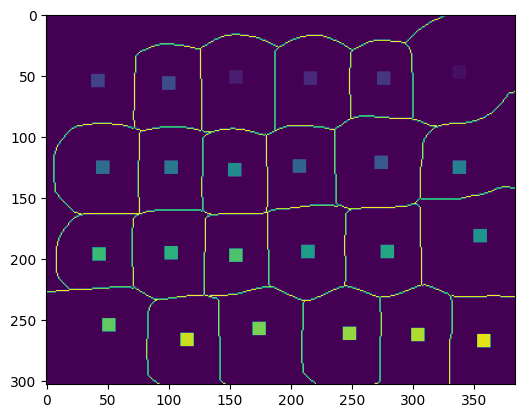

In [ ]:
newmarkers = (phase1seg == 0)*(totalpeaks + 1) + labelpeaks
# for demonstration
plt.imshow(newmarkers)

Top left coin's background seems to be omitted, but that is no problem at all.

Keep in mind that matplotlib optimize the image colors (colormap), so the general purple background represent 0 values. (Normally it should be black. We do not optimize the cmap, for better visualization.)

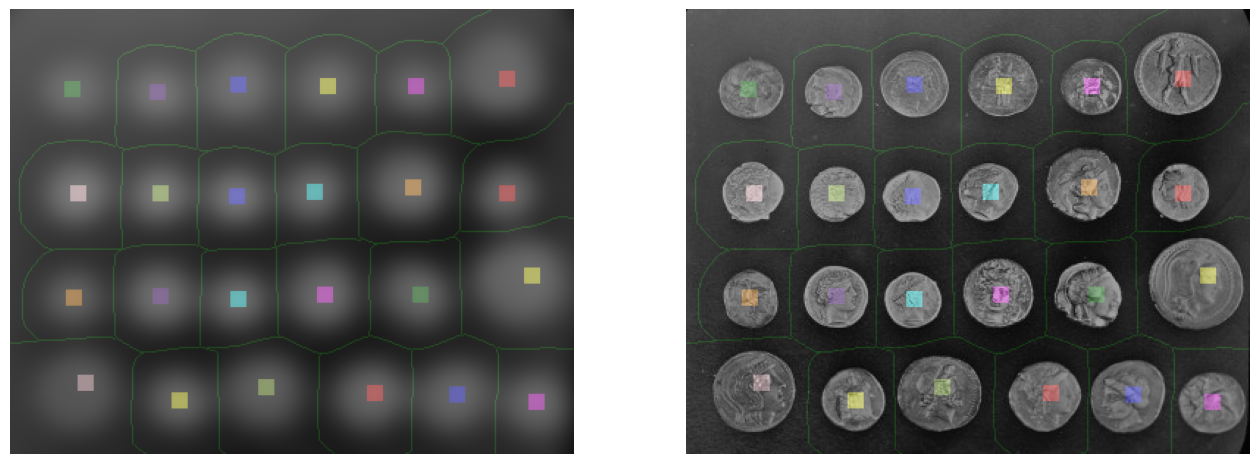

In [ ]:
newmarkers_overlay = skimage.color.label2rgb(newmarkers, image=smoothed, bg_label=0)
newmarkers_overlay_orig = skimage.color.label2rgb(newmarkers, image=coins, bg_label=0)
img = image_show_multi([newmarkers_overlay, newmarkers_overlay_orig], nrows=1, ncols=2)

Check that it looks OK on the original image - all background markers (green) are between coins and foreground markers are inside coins.

Note that the textures inside the coins are likely to cause trouble for our edge operators.

Now we create an edge image for the second phase of segmentation. skimage doesn't have derivative of Gaussian functions so we'll smooth then apply Sobel filters instead ([SkImage Sobel filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel)). A substantial smoothing reduces the chances of holes in the gradient, with the side effect of removing high frequency components. However the outer edges of the coins are smooth so smoothing doesn't matter much.

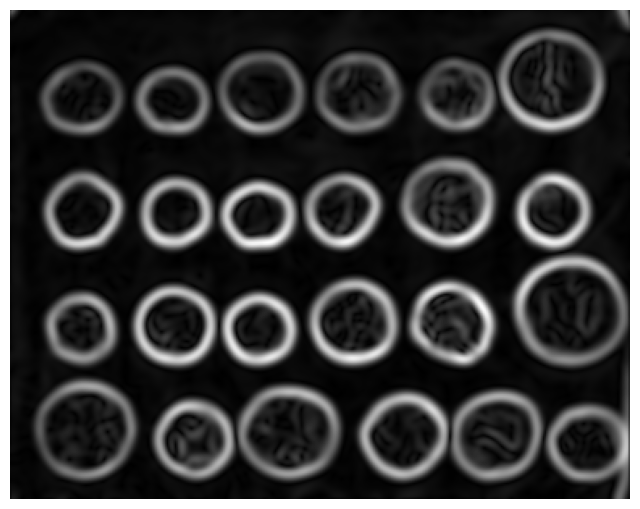

In [ ]:
edges = skimage.filters.gaussian(coins, 3)
edges = skimage.filters.sobel(edges)
img = image_show(edges)

Some patterns can be seen inside of the coins, but that is not a problem, watershed does not care about those.

Finally we apply a watershed on the above created edges image array.

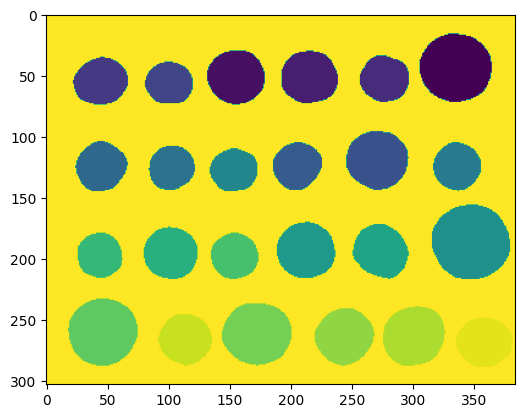

In [ ]:
finalseg = skimage.segmentation.watershed(edges, newmarkers, watershed_line = False)
# demonstration
plt.imshow(finalseg)

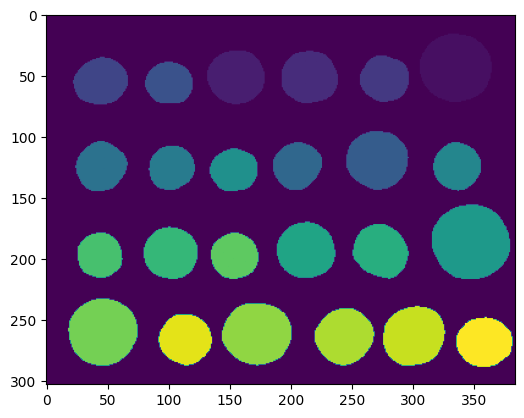

In [ ]:
# remove the background segmentation
finalseg[finalseg == (totalpeaks + 1)] = 0
# demonstration
plt.imshow(finalseg)

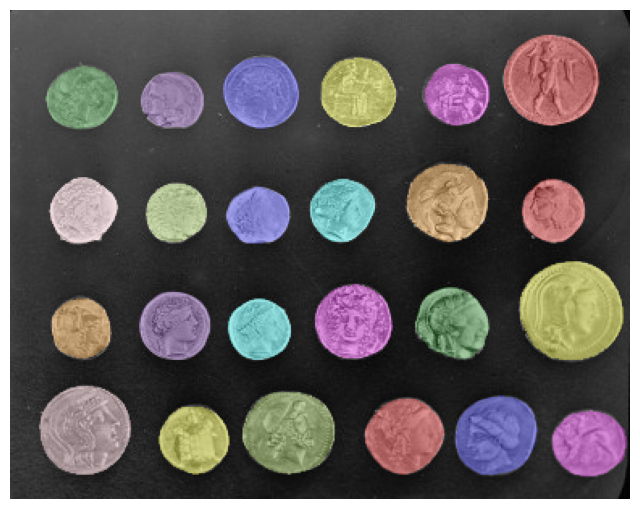

In [ ]:
# display
finalseg_overlay = skimage.color.label2rgb(finalseg, image=coins, bg_label=0)
a = image_show(finalseg_overlay)

Try this technique with SciKit image samples: brick (data.brick()) and checkerboard (data.checkerboard()).

Optimize sigma value in Gaussian filter and check also the inverted greyscale image(s) if you get better solution.